In [1]:

!pip install kafka-python

In [2]:
import os 
packages = "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1"

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages {0} pyspark-shell".format(packages)
)

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
# from pyspark.sql.functions import to_json, struct, lit
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
sc = SparkContext('local')
spark = SparkSession(sc)

KAFKA_BROKER = "kafka:9092"
KAFKA_TOPIC = "DHBKHN"

In [3]:

df=spark.read.format("json").option("mode", "FAILFAST")\
.option("inferSchema", "true").load("hdfs://namenode/user/root/data187001-207670.json")        


In [4]:
df.printSchema()


root
 |-- androidVersion: string (nullable = true)
 |-- category: string (nullable = true)
 |-- comments: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- contentRating: string (nullable = true)
 |-- currentVersion: string (nullable = true)
 |-- installs: long (nullable = true)
 |-- lastUpdate: long (nullable = true)
 |-- price: double (nullable = true)
 |-- ratings: long (nullable = true)
 |-- reviews: long (nullable = true)
 |-- score: double (nullable = true)
 |-- size: string (nullable = true)
 |-- title: string (nullable = true)



In [5]:
df = df.na.drop("all").dropDuplicates()

In [6]:
df = df.filter(size(df['comments']) >= 30)

In [7]:
# !pip install textblob

In [8]:
# from textblob import TextBlob

# def to_sentiment(comments):
#     positive, negative, neutral = 0, 0, 0
#     for comment in comments:
#         sentiment = TextBlob(comment).polarity
#         if sentiment > 0:
#             positive += 1
#         elif sentiment < 0:
#             negative += 1
#         else:
#             neutral += 1
            
#     return [positive, negative, neutral]

# convert = udf(to_sentiment, ArrayType(IntegerType()))

In [9]:
# df = df.withColumn("commentsarr", convert(col("comments")))

In [10]:
# df = df.withColumn('positive', df.commentsarr[0]) \
#         .withColumn('negative', df.commentsarr[1]) \
#         .withColumn('neutral', df.commentsarr[2])

In [11]:
# df=df.drop('commentsarr')

In [12]:
df.printSchema()

root
 |-- androidVersion: string (nullable = true)
 |-- category: string (nullable = true)
 |-- comments: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- contentRating: string (nullable = true)
 |-- currentVersion: string (nullable = true)
 |-- installs: long (nullable = true)
 |-- lastUpdate: long (nullable = true)
 |-- price: double (nullable = true)
 |-- ratings: long (nullable = true)
 |-- reviews: long (nullable = true)
 |-- score: double (nullable = true)
 |-- size: string (nullable = true)
 |-- title: string (nullable = true)



In [13]:
def convertVersion(string):
    try:
        num = int(string[0])
        return num
    except:
        return 0

convert = udf(convertVersion, IntegerType())
df = df.withColumn("android", convert(col("androidVersion")))
df = df.drop("androidVersion")
df = df.withColumn("currentVer", convert(col("currentVersion")))
df = df.drop("currentVersion")



In [14]:
!pip install numpy 

In [15]:
# df = df.fillna(0)

In [16]:
df.printSchema()

root
 |-- category: string (nullable = true)
 |-- comments: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- contentRating: string (nullable = true)
 |-- installs: long (nullable = true)
 |-- lastUpdate: long (nullable = true)
 |-- price: double (nullable = true)
 |-- ratings: long (nullable = true)
 |-- reviews: long (nullable = true)
 |-- score: double (nullable = true)
 |-- size: string (nullable = true)
 |-- title: string (nullable = true)
 |-- android: integer (nullable = true)
 |-- currentVer: integer (nullable = true)



In [17]:
# import numpy as np
# def convertSize(string):
#     if string[-1]=='k':
#         return float(string.rstrip('k'))/1024
#     if string[-1]=='M':
#         return float(string.rstrip('M'))
#     return np.nan
# convert = udf(convertSize, DoubleType())
# df = df.withColumn("sizeInt", convert(col("size")))
# df = df.drop("size")

# df.select("sizeInt").show()

In [18]:
df.show()

+-----------------+--------------------+-------------+---------+----------+-----+-------+-------+---------+----+--------------------+-------+----------+
|         category|            comments|contentRating| installs|lastUpdate|price|ratings|reviews|    score|size|               title|android|currentVer|
+-----------------+--------------------+-------------+---------+----------+-----+-------+-------+---------+----+--------------------+-------+----------+
|           Casual|[I actually prefe...|     Everyone| 10000000|1506984625|  0.0| 420048| 140455|4.3211493| 20M|       Bakery Story™|      2|         1|
|            Board|[Worst game app o...|     Everyone|  1000000|1594220079|  0.0|  20851|   5303| 4.099952| 13M|         Tic Tac Toe|      4|         0|
|Books & Reference|[a good option to...|     Everyone|    10000|1598518788|  0.0|    558|    271|     4.59| 31M|English-spanish a...|      4|         2|
|        Education|[I am preparing f...|     Everyone|    50000|1560243757|  0.0| 

In [19]:
df = df.withColumn('value' ,to_json(struct([df[x] for x in df.columns])))
df.selectExpr("CAST(title AS STRING) as key", "CAST(value AS STRING) as valuess").show(5)

+--------------------+--------------------+
|                 key|             valuess|
+--------------------+--------------------+
|       Bakery Story™|{"category":"Casu...|
|         Tic Tac Toe|{"category":"Boar...|
|English-spanish a...|{"category":"Book...|
|    TOEFL Vocabulary|{"category":"Educ...|
|   Online Dictionary|{"category":"Book...|
+--------------------+--------------------+
only showing top 5 rows



In [20]:
df.selectExpr("CAST(title AS STRING) as key", "CAST(value AS STRING)")\
  .write\
  .format("kafka")\
  .option("kafka.bootstrap.servers", KAFKA_BROKER)\
  .option("topic", KAFKA_TOPIC)\
  .save()

In [21]:
df = df.withColumn('topic' ,lit(KAFKA_TOPIC))
df.selectExpr('topic', "CAST(title AS STRING) as key", "CAST(value AS STRING)").show(10)

+------+--------------------+--------------------+
| topic|                 key|               value|
+------+--------------------+--------------------+
|DHBKHN|       Bakery Story™|{"category":"Casu...|
|DHBKHN|         Tic Tac Toe|{"category":"Boar...|
|DHBKHN|English-spanish a...|{"category":"Book...|
|DHBKHN|    TOEFL Vocabulary|{"category":"Educ...|
|DHBKHN|   Online Dictionary|{"category":"Book...|
|DHBKHN|IELTS Test Listen...|{"category":"Educ...|
|DHBKHN|Daily English Lis...|{"category":"Educ...|
|DHBKHN|Learn English - 6...|{"category":"Educ...|
|DHBKHN|EngVoice: Learn E...|{"category":"Educ...|
|DHBKHN|Spanish English D...|{"category":"Educ...|
+------+--------------------+--------------------+
only showing top 10 rows



In [22]:
df = spark\
.read\
.format("kafka")\
.option("kafka.bootstrap.servers", "kafka:9092")\
.option("subscribe",KAFKA_TOPIC)\
.load()

df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)").show()
df.count()

+--------------------+--------------------+
|                 key|               value|
+--------------------+--------------------+
|       Bakery Story™|{"category":"Casu...|
|         Tic Tac Toe|{"category":"Boar...|
|English-spanish a...|{"category":"Book...|
|    TOEFL Vocabulary|{"category":"Educ...|
|   Online Dictionary|{"category":"Book...|
|IELTS Test Listen...|{"category":"Educ...|
|Daily English Lis...|{"category":"Educ...|
|Learn English - 6...|{"category":"Educ...|
|EngVoice: Learn E...|{"category":"Educ...|
|Spanish English D...|{"category":"Educ...|
|Learn Japanese Vo...|{"category":"Educ...|
|Swedish Words Lea...|{"category":"Educ...|
|Tanakh, Torah, Te...|{"category":"Book...|
|Drop The Number™ ...|{"category":"Puzz...|
|Wood Block Puzzle...|{"category":"Puzz...|
|         Coin Bubble|{"category":"Casu...|
|Ice Scream 1: Hor...|{"category":"Arca...|
|Guitar Girl : Rel...|{"category":"Simu...|
|     Pet Rescue Saga|{"category":"Casu...|
|Mechanic Mike - M...|{"category

16040

In [23]:
df_list = df.collect()

In [24]:
arr=[]
for item in df_list:
    arr.append(item.asDict())

In [25]:
arr

[{'key': bytearray(b'Bakery Story\xe2\x84\xa2'),
  'value': bytearray(b'{"category":"Casual","comments":["I actually prefer this version to the new one. Ive always used it as a relaxing time wasting app. Its very simple yet pleasing to the eye. Not 3D but I enjoy the simplicity. I used to use it yrs ago while in college to distract my brain when in the middle of finals or midterms.. good brain break. Im not ond of those who can simply meditate or something. I need something to keep me busy while I relax. Now through a pandemic im a busy mom and its nice to take a moment.. build up a bakery.","No notifications, goals can\'t be completed because the items no longer exist in the buying menu, and the food glitches to the point where it erases it entirely. I can\'t even cook anything on an oven because it keeps vanishing, the actual oven not the food. It erases things I buy and prevents customers from coming in. Closing/refreshing the app doesn\'t work, it just keeps glitching and I spent h

In [19]:
df = df.drop('title')

In [20]:
!pip install seaborn

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('ggplot')

In [22]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

Py4JJavaError: An error occurred while calling z:org.apache.spark.ml.stat.Correlation.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 14.0 failed 1 times, most recent failure: Lost task 0.0 in stage 14.0 (TID 411, 49f5e5e0a58e, executor driver): org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$3023/972737914: (struct<installs_double_VectorAssembler_c48a4527cdde:double,lastUpdate_double_VectorAssembler_c48a4527cdde:double,price:double,ratings_double_VectorAssembler_c48a4527cdde:double,reviews_double_VectorAssembler_c48a4527cdde:double,score:double,positive_double_VectorAssembler_c48a4527cdde:double,negative_double_VectorAssembler_c48a4527cdde:double,neutral_double_VectorAssembler_c48a4527cdde:double,android_double_VectorAssembler_c48a4527cdde:double,currentVer_double_VectorAssembler_c48a4527cdde:double,categoryIndex:double,UserType:double,sizeInt:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:162)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:160)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1429)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:219)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:219)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1204)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1205)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:837)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:837)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Encountered NaN while assembling a row with handleInvalid = "error". Consider
removing NaNs from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:264)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 36 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2188)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1157)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1151)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1220)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1196)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeCovariance(RowMatrix.scala:436)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelationMatrix(PearsonCorrelation.scala:49)
	at org.apache.spark.mllib.stat.correlation.Correlations$.corrMatrix(Correlation.scala:66)
	at org.apache.spark.mllib.stat.Statistics$.corr(Statistics.scala:90)
	at org.apache.spark.ml.stat.Correlation$.corr(Correlation.scala:71)
	at org.apache.spark.ml.stat.Correlation.corr(Correlation.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$3023/972737914: (struct<installs_double_VectorAssembler_c48a4527cdde:double,lastUpdate_double_VectorAssembler_c48a4527cdde:double,price:double,ratings_double_VectorAssembler_c48a4527cdde:double,reviews_double_VectorAssembler_c48a4527cdde:double,score:double,positive_double_VectorAssembler_c48a4527cdde:double,negative_double_VectorAssembler_c48a4527cdde:double,neutral_double_VectorAssembler_c48a4527cdde:double,android_double_VectorAssembler_c48a4527cdde:double,currentVer_double_VectorAssembler_c48a4527cdde:double,categoryIndex:double,UserType:double,sizeInt:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:162)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:160)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1429)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:219)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:219)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1204)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1205)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:837)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:837)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered NaN while assembling a row with handleInvalid = "error". Consider
removing NaNs from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:264)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 36 more


In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.toPandas().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

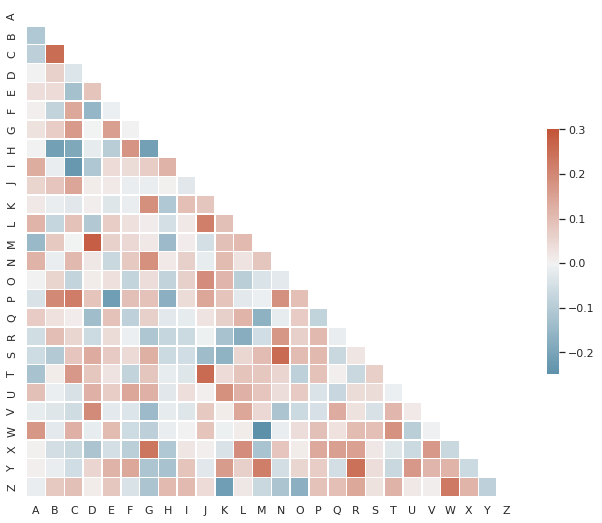

In [23]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})